# This file contains code that can be used to visualize your results and analize the uncertainty score performance.

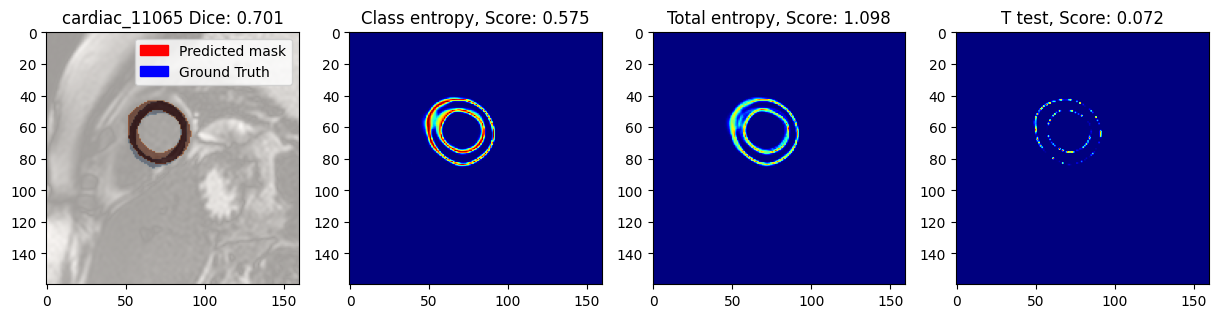

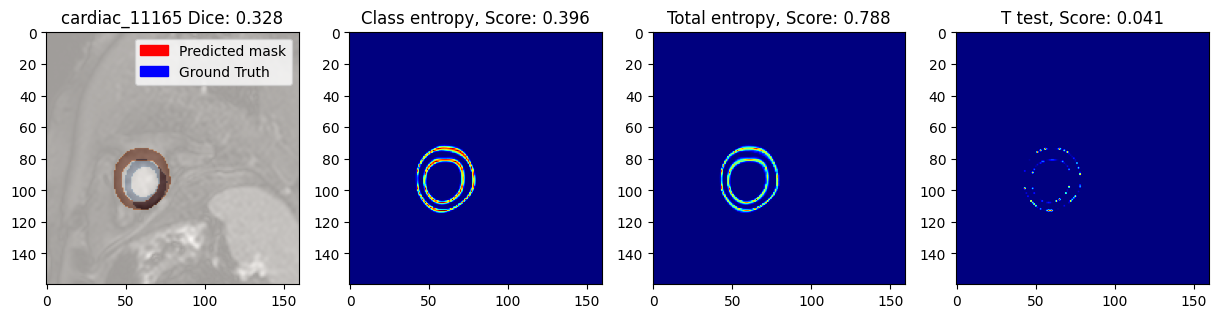

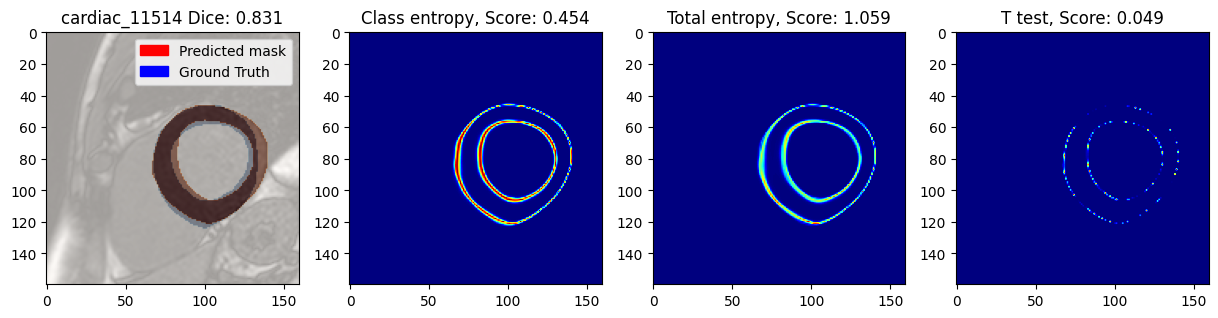

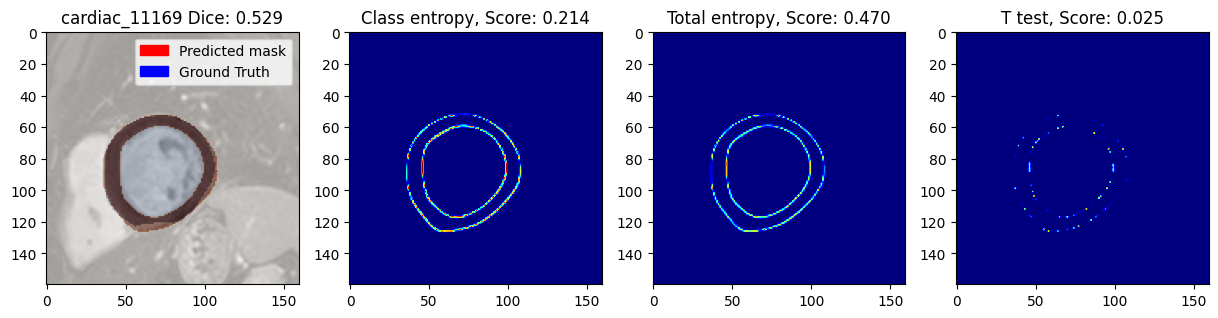

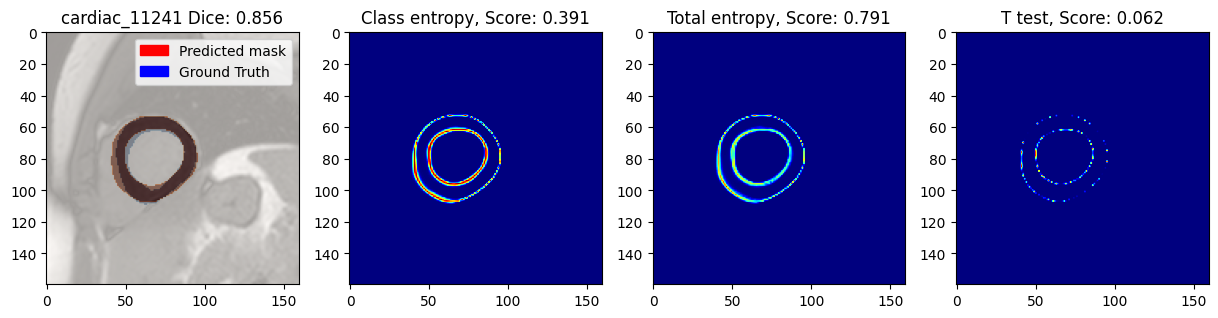

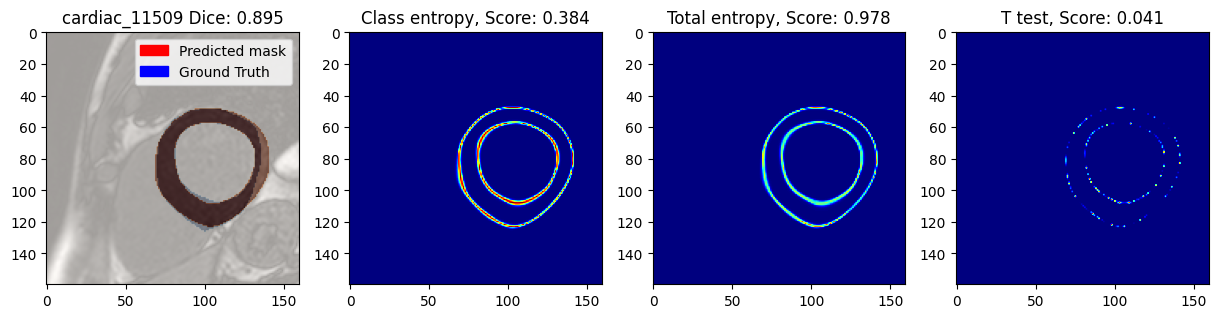

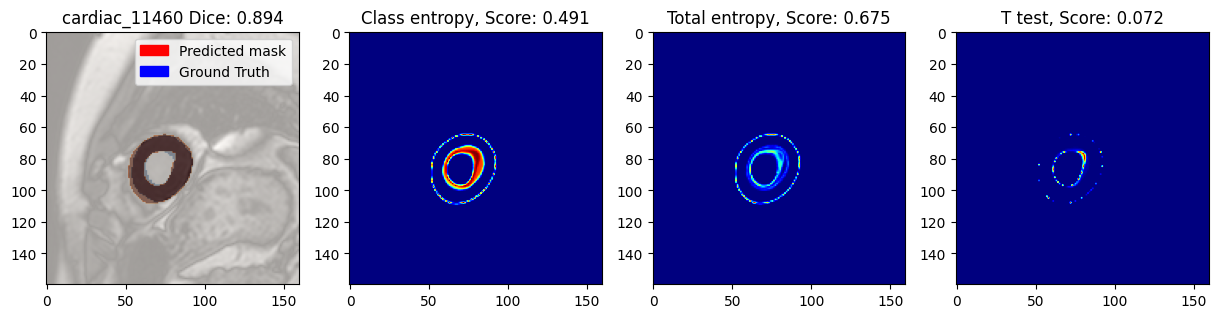

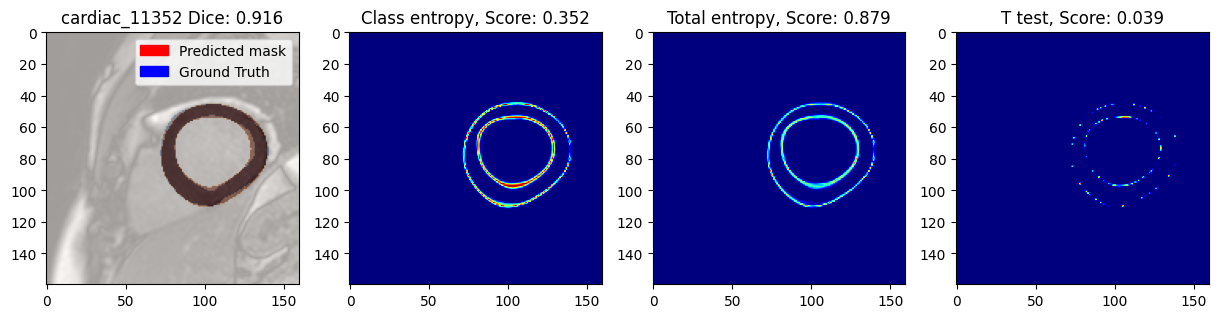

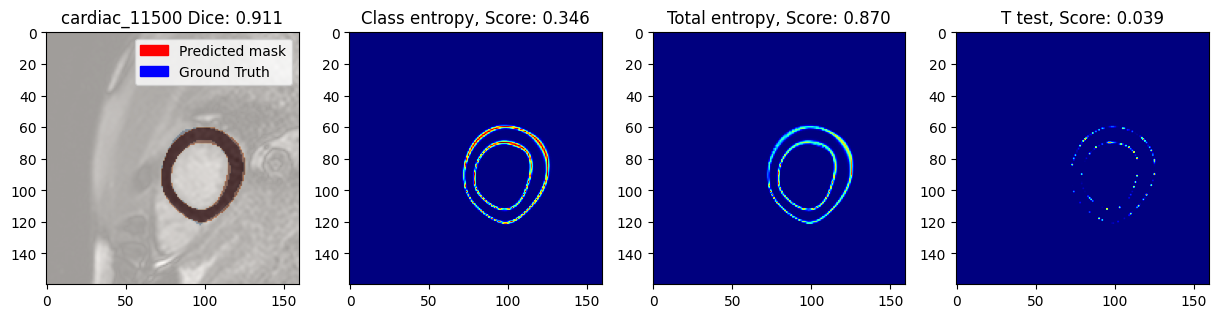

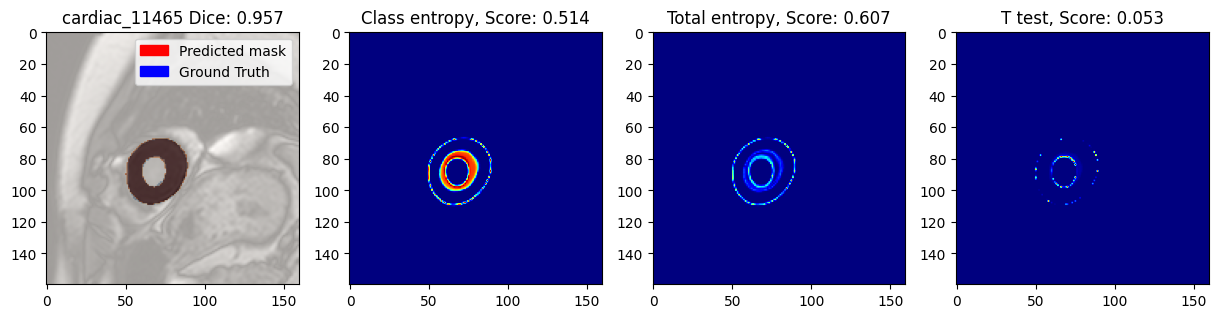

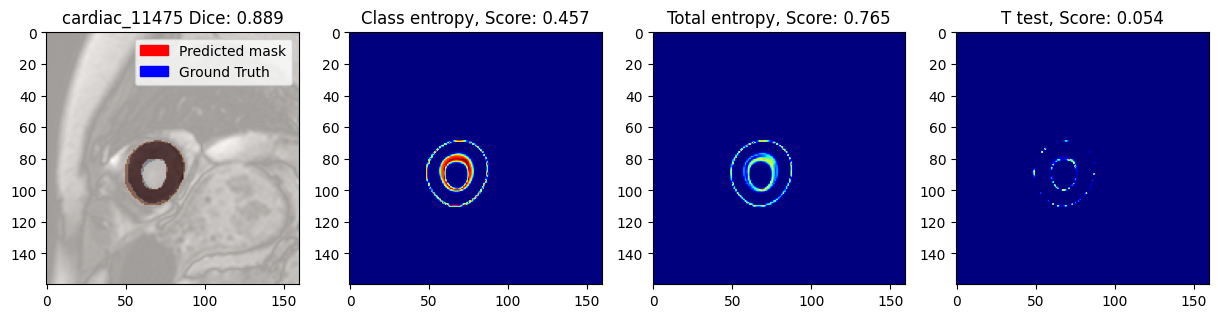

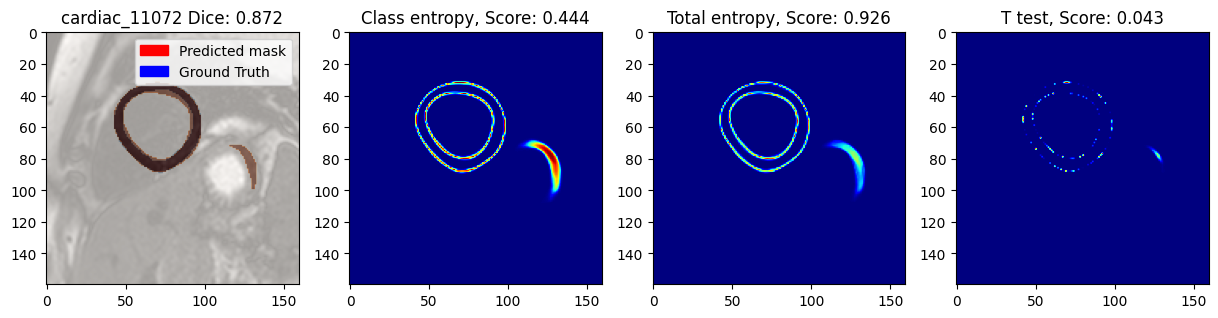

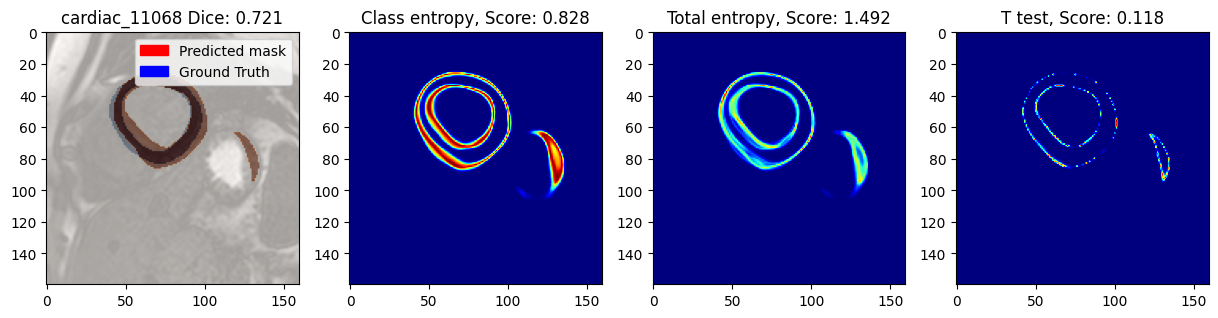

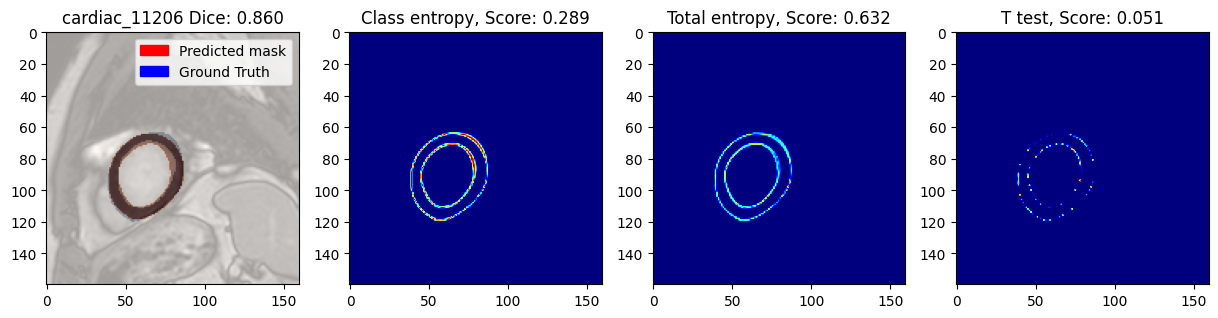

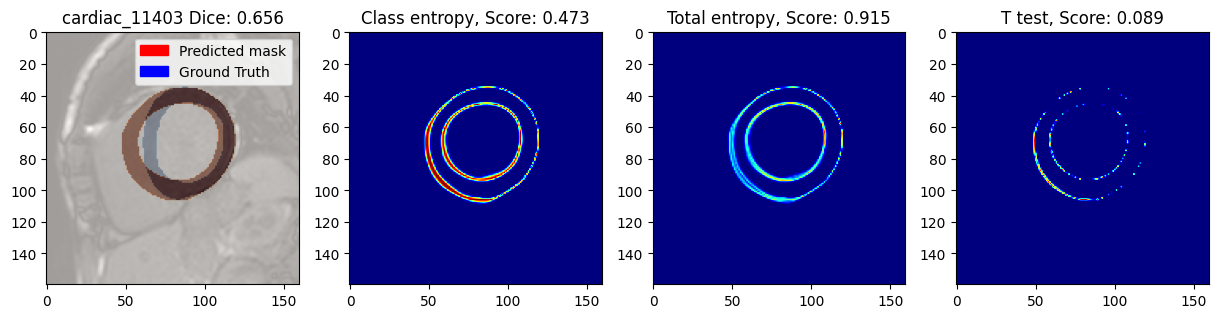

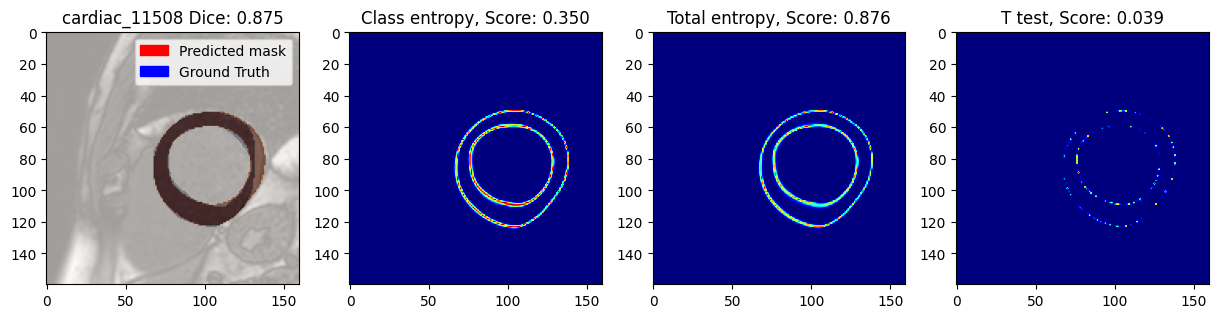

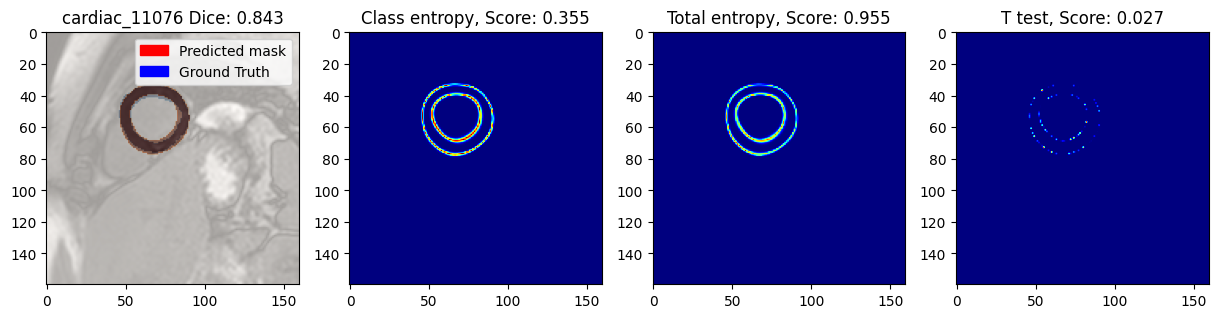

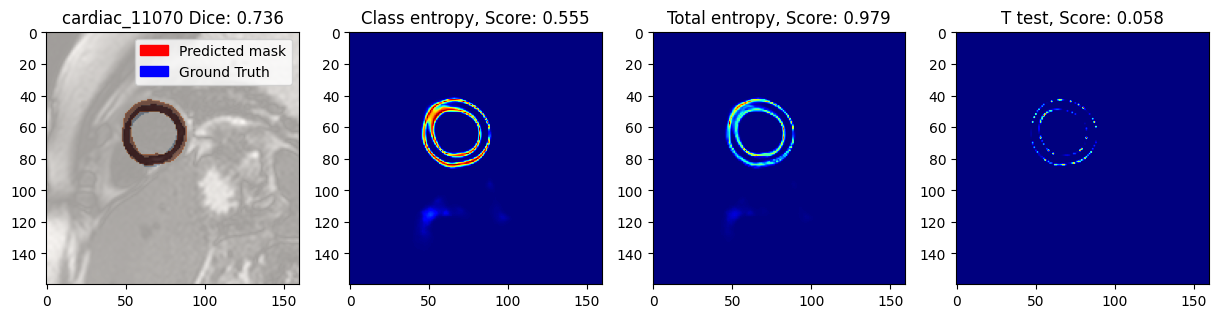

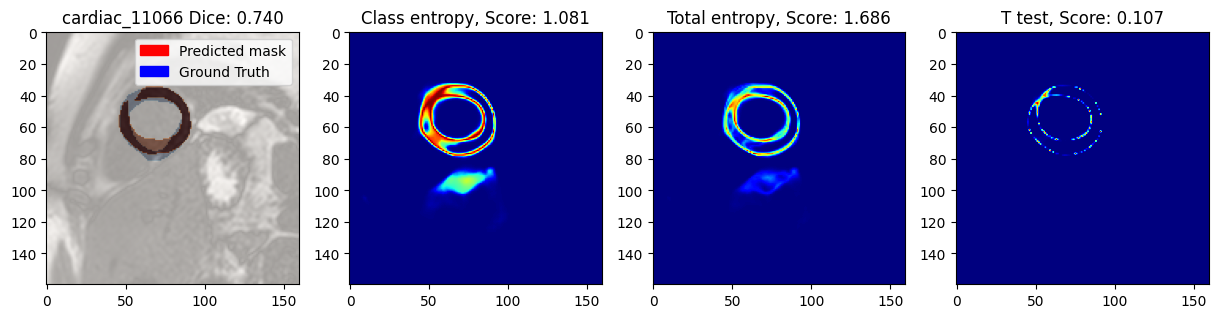

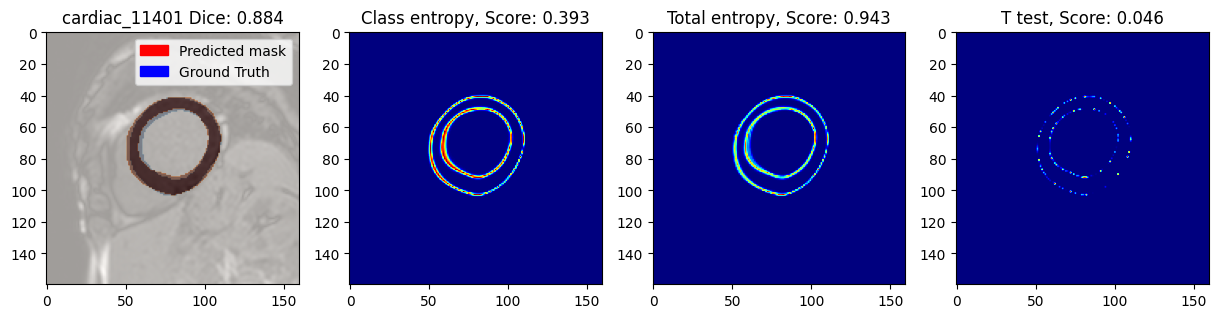

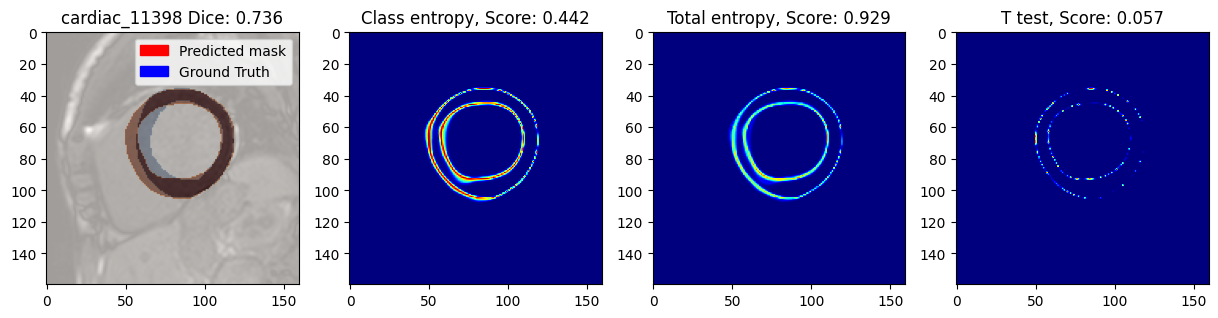

In [36]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

raw_path = r'/home/danielkatz/UnnUNet/datasets/nnUNet_raw/Dataset500_cardiac'
results_path = r'/home/danielkatz/UnnUNet/datasets/nnUNet_results/Dataset500_cardiac/nnUNetTrainer__nnUNetPlans__2d'

ce_scores = pd.read_csv(results_path + '/uncertainty_class_entropy/uncertainty_scores.csv')
te_scores = pd.read_csv(results_path + '/uncertainty_total_entropy/uncertainty_scores.csv')
tt_scores = pd.read_csv(results_path + '/uncertainty_t_test/uncertainty_scores.csv')

#get images names
images = [x for x in os.listdir(raw_path + '/imagesTs/') if x.endswith('.nii.gz')]
count   = 0
for image in images:
    
    #load image and raw data
    raw_image = nib.load(raw_path + '/imagesTs/' + image).get_fdata()
    gt_mask = nib.load(raw_path + '/labelsTs/' + image.replace("_0000","")).get_fdata()
    pred_mask = nib.load(results_path + '/uncertainty_class_entropy/' + image.replace("_0000","_predicted_mask")).get_fdata()
    ce_map = nib.load(results_path + '/uncertainty_class_entropy/' + image.replace("_0000","_uncertainty_map")).get_fdata()
    te_map = nib.load(results_path + '/uncertainty_total_entropy/' + image.replace("_0000","_uncertainty_map")).get_fdata()
    tt_map = nib.load(results_path + '/uncertainty_t_test/' + image.replace("_0000","_uncertainty_map")).get_fdata()

    #load uncertainty scores
    ce_score = ce_scores.loc[ce_scores['image_name'] == image.replace("_0000.nii.gz","")]['uncertainty_score'].values[0]
    te_score = te_scores.loc[te_scores['image_name'] == image.replace("_0000.nii.gz","")]['uncertainty_score'].values[0]
    tt_score = tt_scores.loc[tt_scores['image_name'] == image.replace("_0000.nii.gz","")]['uncertainty_score'].values[0]
    dice_score = ce_scores.loc[ce_scores['image_name'] == image.replace("_0000.nii.gz","")]['dice_score'].values[0]
    
    #plot images in one row; raw image + ground truth + predicted mask , uncertainty map ce , uncertainty map te , uncertainty map tt
    #add titles ; image name + deice score, ce score, te score, tt score
    if count > 20:
        break
    if dice_score < 0.6 or ce_score > 0.4 or te_score > 0.85 or tt_score > 0.05:
        count += 1


        fig, axs = plt.subplots(1, 4, figsize = (15,20)) #create figure with 5 subplots
        #add colorbar
    
        axs[0].imshow(raw_image, cmap='gray') #plot raw image
        axs[0].imshow( gt_mask, cmap='Blues', alpha = 0.4) #plot ground truth mask
        axs[0].imshow( pred_mask, cmap='Oranges', alpha = 0.4) #plot ground truth mask
        
        axs[0].legend(handles = [Patch(facecolor='red', edgecolor='r',label='Predicted mask'), Patch(facecolor='blue', edgecolor='b', label='Ground Truth')] , )  # add legend

        

        axs[0].set_title(image.split("_0000.")[0] + ' Dice: ' + "%.3f" % dice_score) #add title to subplot

        axs[1].imshow(np.transpose(ce_map) , cmap='jet') #plot ce map
        axs[1].set_title('Class entropy, Score: ' + "%.3f" % ce_score) #add title to subplot

        axs[2].imshow(np.transpose(te_map) , cmap='jet') #plot te map
        axs[2].set_title('Total entropy, Score: ' + "%.3f" % te_score) #add title to subplot
        

        axs[3].imshow(tt_map, cmap='jet') #plot tt map
        axs[3].set_title('T test, Score: ' + "%.3f" % tt_score) #add title to subplot

        plt.show() #show figure


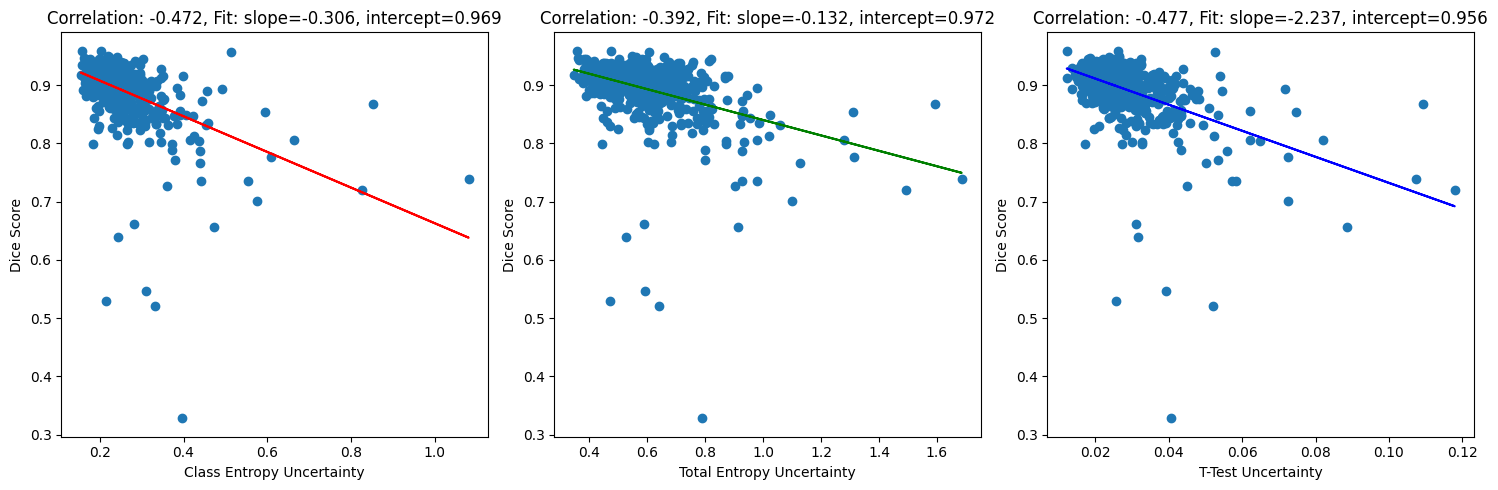

Class Entropy: Slope=-0.306, Intercept=0.969, Correlation=-0.472
Total Entropy: Slope=-0.132, Intercept=0.972, Correlation=-0.392
T-Test: Slope=-2.237, Intercept=0.956, Correlation=-0.477


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dice_scores = ce_scores['dice_score']
ce_uncertainty_scores = ce_scores['uncertainty_score']
te_uncertainty_scores = te_scores['uncertainty_score']
tt_uncertainty_scores = tt_scores['uncertainty_score']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatter plots with best-fit lines and set titles
axs[0].scatter(ce_uncertainty_scores, dice_scores)
ce_fit = np.polyfit(ce_uncertainty_scores, dice_scores, 1)
axs[0].plot(ce_uncertainty_scores, np.polyval(ce_fit, ce_uncertainty_scores), color='red')
ce_corr = np.corrcoef(ce_uncertainty_scores, dice_scores)[0, 1]
axs[0].set_title('Correlation: {:.3f}, Fit: slope={:.3f}, intercept={:.3f}'.format(ce_corr, ce_fit[0], ce_fit[1]))
axs[0].set_xlabel('Class Entropy Uncertainty')
axs[0].set_ylabel('Dice Score')

axs[1].scatter(te_uncertainty_scores, dice_scores)
te_fit = np.polyfit(te_uncertainty_scores, dice_scores, 1)
axs[1].plot(te_uncertainty_scores, np.polyval(te_fit, te_uncertainty_scores), color='green')
te_corr = np.corrcoef(te_uncertainty_scores, dice_scores)[0, 1]
axs[1].set_title('Correlation: {:.3f}, Fit: slope={:.3f}, intercept={:.3f}'.format(te_corr, te_fit[0], te_fit[1]))
axs[1].set_xlabel('Total Entropy Uncertainty')
axs[1].set_ylabel('Dice Score')

axs[2].scatter(tt_uncertainty_scores, dice_scores)
tt_fit = np.polyfit(tt_uncertainty_scores, dice_scores, 1)
axs[2].plot(tt_uncertainty_scores, np.polyval(tt_fit, tt_uncertainty_scores), color='blue')
tt_corr = np.corrcoef(tt_uncertainty_scores, dice_scores)[0, 1]
axs[2].set_title('Correlation: {:.3f}, Fit: slope={:.3f}, intercept={:.3f}'.format(tt_corr, tt_fit[0], tt_fit[1]))
axs[2].set_xlabel('T-Test Uncertainty')
axs[2].set_ylabel('Dice Score')

plt.tight_layout()
plt.show()

print("Class Entropy: Slope={:.3f}, Intercept={:.3f}, Correlation={:.3f}".format(ce_fit[0], ce_fit[1], ce_corr))
print("Total Entropy: Slope={:.3f}, Intercept={:.3f}, Correlation={:.3f}".format(te_fit[0], te_fit[1], te_corr))
print("T-Test: Slope={:.3f}, Intercept={:.3f}, Correlation={:.3f}".format(tt_fit[0], tt_fit[1], tt_corr))
